In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv, det
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv("iris_train.csv", index_col=0)
test_df = pd.read_csv("iris_test.csv", index_col=0)

In [3]:
train_df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
22,4.6,3.6,1.0,0.2,Iris-setosa
15,5.7,4.4,1.5,0.4,Iris-setosa
65,6.7,3.1,4.4,1.4,Iris-versicolor
11,4.8,3.4,1.6,0.2,Iris-setosa
42,4.4,3.2,1.3,0.2,Iris-setosa


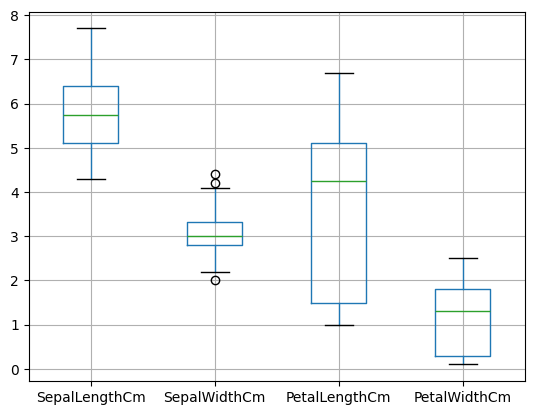

In [4]:
train_df.boxplot()
plt.show()

# **PART I**

### **Applying PCA to reduce dimension to one**

**Removing outliers first**

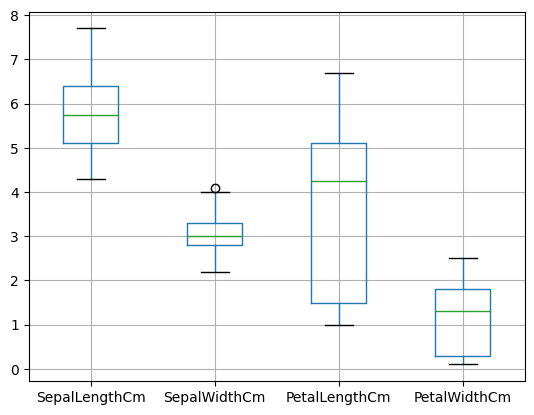

In [5]:
train_df_X = train_df.iloc[:,:-1]
Q1 = train_df_X.quantile(0.25)
Q3 = train_df_X.quantile(0.75)
IQR = Q3 - Q1
newdf = np.where((train_df_X <= (Q1 - 1.5*IQR)) | (train_df_X >= (Q3 +1.5*IQR)), train_df_X.median(),train_df_X)
train_df.iloc(axis=1)[:-1] = newdf
train_df.boxplot()
plt.show()

**Applying PCA**

In [6]:
def PCA(t_df,dim:int, training_df = train_df):
    X = t_df.iloc[:,:-1]
    C = X.cov()
    eign_val = np.linalg.eig(C).eigenvalues
    eign_vec = np.linalg.eig(C).eigenvectors
    order_ind = np.argsort(eign_val)[::-1]
    d_eign_vec = eign_vec[:,order_ind][:,:dim]
    X_tra_proj = np.matmul(X,d_eign_vec)
    train_df_proj = pd.DataFrame()
    train_df_proj['proj1'] = X_tra_proj
    train_df_proj['Species'] = t_df['Species']
    return train_df_proj

In [7]:
train_proj = PCA(train_df, 1)
train_proj.head()

,proj1,Species
22,2.322956,Iris-setosa
15,3.264348,Iris-setosa
65,6.464326,Iris-versicolor
11,2.924863,Iris-setosa
42,2.537863,Iris-setosa


In [8]:
test_proj = PCA(test_df,1)
test_proj.head()

,proj1,Species
73,6.483014,Iris-versicolor
18,3.378686,Iris-setosa
118,9.360807,Iris-virginica
78,6.378617,Iris-versicolor
76,6.897239,Iris-versicolor


In [9]:
no_of_classes = len(train_df['Species'].value_counts()) # = 3

**Train Bayes Classifier**

In [10]:
train_proj.groupby('Species',sort=False).mean()

,proj1
Species,
Iris-setosa,2.883752
Iris-versicolor,6.041455
Iris-virginica,7.590380


**My custom stats functions**

In [11]:
def custom_mean(group):
    numeric_cols = group.select_dtypes(include='number')
    mean_values = numeric_cols.sum() / len(group)
    return mean_values

def custom_std(group):
    numeric_cols = group.select_dtypes(include='number')
    mean_values = numeric_cols.sum() / len(group)
    variance = ((numeric_cols - mean_values) ** 2).sum() / len(group)
    std_dev = np.sqrt(variance)
    return std_dev

def custom_cov(group):
    numeric_cols = group.select_dtypes(include='number')
    mean_values = custom_mean(group)
    centered = numeric_cols - mean_values
    cov_matrix = (centered.T @ centered) / len(group)
    return cov_matrix

**<---my custom functions ENDS HERE--->**

In [12]:
uni_means = train_proj.groupby('Species').mean().to_numpy().reshape((no_of_classes,))
uni_means

array([2.88375184, 6.04145463, 7.59038021])

In [13]:
uni_stds = train_proj.groupby('Species').std(ddof=0).to_numpy().reshape((no_of_classes,))
uni_stds

array([0.23339069, 0.61318947, 0.6993269 ])

In [14]:
(train_df['Species'].value_counts(sort=False) / sum(train_df['Species'].value_counts())).to_numpy().reshape((no_of_classes,))

array([0.33333333, 0.34166667, 0.325     ])

In [15]:
class Bayes_classifier:
    def __init__(self,train_proj:pd.DataFrame,train_df=train_df, univariate:bool = True):
        self.tr_proj = train_proj
        self.variate = univariate
        self.n_col = len(train_df.iloc[:,:-1].columns) # here  = 4
        self.n_c = len(train_df['Species'].value_counts()) # here = 3
        self.class_prob = (train_df['Species'].value_counts(sort=False) / sum(train_df['Species'].value_counts())).to_numpy().reshape((self.n_c,))
    
    def statistics(self):
        if (self.variate==True):
            uni_means = self.tr_proj.groupby('Species',sort=False).apply(custom_mean).to_numpy().reshape((self.n_c,))
            uni_stds = self.tr_proj.groupby('Species',sort=False).apply(custom_std).to_numpy().reshape((self.n_c,))
            return uni_means, uni_stds
        else:
            multi_means = train_df.groupby('Species',sort=False).apply(custom_mean).to_numpy()
            multi_stds = train_df.groupby('Species',sort=False).apply(custom_cov).to_numpy().reshape((self.n_c,self.n_col,self.n_col)) # reshaped to (3,4,4) so that I can access cov matrices by indices
            return multi_means, multi_stds
    
    def L(self,x, i:int):
        mu, sigma = self.statistics()
        mu = mu[i]
        sigma = sigma[i]
        class_prob = self.class_prob[i]
        if self.variate:
            P = np.exp(-(((x-mu)/sigma)**2)/2) / (np.sqrt(2*np.pi) * sigma)            
            return  P * class_prob
        else:
            dist = np.matmul(x-mu, inv(sigma))
            dist = np.matmul(dist,(x-mu).T)
            dist = -dist/2
            P = np.exp(dist) / (pow(2*np.pi,self.n_col/2) * det(sigma)**0.5)
            return P * class_prob

    def Predict(self,x):
        likelihoods = []
        for i in range(self.n_c):
            likelihoods.append(self.L(x,i))
        return np.argsort(likelihoods)[-1]


```
Ignore my Bayes clf testing
```

In [16]:
mybayes = Bayes_classifier(train_proj)
mybayes.L(6.464326,1)

0.17524524678311834

**Testing Time 😎**

In [17]:
classes_lst = list(train_df.groupby(sort=False, by='Species').groups.keys())
classes_lst

['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

In [18]:
test_proj['Species'].value_counts()

Species
Iris-virginica     11
Iris-setosa        10
Iris-versicolor     9
Name: count, dtype: int64

In [19]:
X_test_uni = test_proj['proj1'] #removing class labels

In [20]:
Y_pred_uni = []
myclf = Bayes_classifier(train_proj)
for i in X_test_uni:
    Y_pred_uni.append(classes_lst[myclf.Predict(i)])

**Evaluation Time**

In [21]:
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

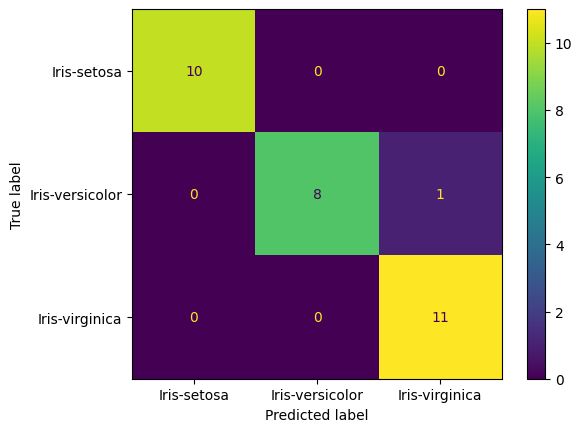

In [22]:
# confusion_matrix(y_pred=Y_pred_uni, y_true=test_df['Species'])
ConfusionMatrixDisplay.from_predictions(test_df['Species'], Y_pred_uni)
plt.savefig("PART1_CM.png")
plt.show()

In [23]:
accuracy_score(y_pred=Y_pred_uni, y_true=test_df['Species'])

0.9666666666666667

# **PART II**

In [24]:
train_df

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
22,4.6,3.6,1.0,0.2,Iris-setosa
15,5.7,3.0,1.5,0.4,Iris-setosa
65,6.7,3.1,4.4,1.4,Iris-versicolor
11,4.8,3.4,1.6,0.2,Iris-setosa
42,4.4,3.2,1.3,0.2,Iris-setosa
...,...,...,...,...,...
71,6.1,2.8,4.0,1.3,Iris-versicolor
106,4.9,2.5,4.5,1.7,Iris-virginica
14,5.8,4.0,1.2,0.2,Iris-setosa
92,5.8,2.6,4.0,1.2,Iris-versicolor


**Testing Time 😎**

In [25]:
test_df

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
73,6.1,2.8,4.7,1.2,Iris-versicolor
18,5.7,3.8,1.7,0.3,Iris-setosa
118,7.7,2.6,6.9,2.3,Iris-virginica
78,6.0,2.9,4.5,1.5,Iris-versicolor
76,6.8,2.8,4.8,1.4,Iris-versicolor
31,5.4,3.4,1.5,0.4,Iris-setosa
64,5.6,2.9,3.6,1.3,Iris-versicolor
141,6.9,3.1,5.1,2.3,Iris-virginica
68,6.2,2.2,4.5,1.5,Iris-versicolor
82,5.8,2.7,3.9,1.2,Iris-versicolor


In [26]:
X_test_multi = test_df.iloc[:,:-1].to_numpy()


In [27]:
Y_pred_multi = []
myclf = Bayes_classifier(train_df,univariate=False)
for i in X_test_multi:
    Y_pred_multi.append(classes_lst[myclf.Predict(i)])

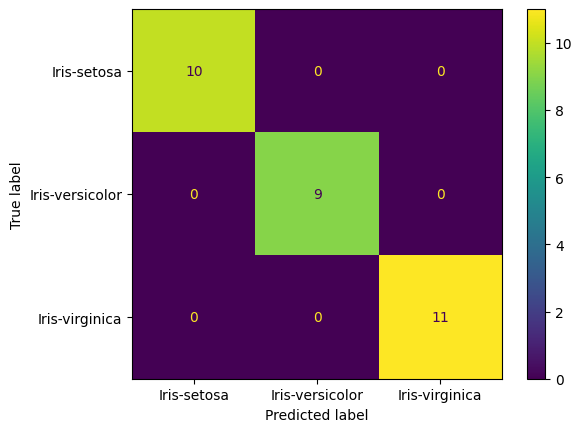

In [28]:
# confusion_matrix(y_pred=Y_pred_uni, y_true=test_df['Species'])
ConfusionMatrixDisplay.from_predictions(test_df['Species'], Y_pred_multi)
plt.savefig("PART2_CM.png")
plt.show()

In [29]:
accuracy_score(test_df['Species'], Y_pred_multi)

1.0

# **III**

In [30]:
1.-0.96667

0.03332999999999997

**As we can see, the accuracy of Bayes_classifier for reduced-dimesion data is less by 0.033 than the original data.**\
**So by this implies, PCA does loose some information while reducing the computation time and memory. Thus, we have a trade-off between money and accuracy.**